In [1]:
import os
import gc
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import random
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
## plug in gdrive to load the data from gdrive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
## Load dataset
path = '/content/drive/MyDrive/Fellowship_Deep_and_Wide_Bandit/Test_Dataset/'

train_df = pd.read_csv(path+'data_user_reaction.csv')

In [4]:
## Replace event 3 with 2
train_df['event'][train_df['event']==3] = 2

In [5]:
train_df.head()

,person,gender,age,income,reg_year,reg_month,reg_day,time,event,offer_type,offer_id,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social
0,12,1,58,51000,2017,11,11,0,0,1,2,0,0,4,1,1,1,0
1,29,1,59,41000,2015,1,21,0,0,0,3,0,5,7,1,1,1,0
2,47,0,54,80000,2017,2,7,0,0,0,3,0,5,7,1,1,1,0
3,69,1,76,64000,2014,8,31,0,0,0,0,0,10,7,0,1,1,1
4,86,0,74,107000,2015,12,24,0,0,1,2,0,0,4,1,1,1,0


In [6]:
train_df.groupby('event').mean()

,person,gender,age,income,reg_year,reg_month,reg_day,time,offer_type,offer_id,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social
event,,,,,,,,,,,,,,,,,
0,8561.660286,0.661724,52.307360,60500.404422,2016.753393,6.626943,15.981486,339.310865,1.228723,4.240047,0.000000,8.098140,6.584344,0.898715,1.0,0.752314,0.150984
1,8492.205827,0.658937,53.326816,62103.961667,2016.826003,6.622615,15.935184,352.108668,0.819543,4.355438,0.000000,5.377513,5.372722,0.632284,1.0,0.970437,0.744203
2,8474.505563,0.537375,55.847656,69452.250000,2016.427344,6.765625,15.861781,397.903125,1.056250,4.683063,4.950031,9.287437,7.309812,0.887375,1.0,0.897531,0.647719


In [7]:
train_df.groupby('event').std()

,person,gender,age,income,reg_year,reg_month,reg_day,time,offer_type,offer_id,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social
event,,,,,,,,,,,,,,,,,
0,4905.303933,0.491042,18.359731,22040.734412,1.242389,3.475091,8.714674,193.504252,0.770484,2.641635,0.000000,7.790274,2.435628,0.301720,0.0,0.431688,0.358049
1,4880.038322,0.502722,17.549293,20387.156118,1.223169,3.477059,8.762336,202.685974,0.753004,2.961461,0.000000,5.076267,2.131264,0.482194,0.0,0.169381,0.436318
2,4899.708106,0.528606,16.800194,21598.308329,1.131652,3.508207,8.721890,192.953090,0.998432,2.863978,2.907144,4.185524,1.769743,0.316139,0.0,0.303268,0.477688


In [8]:
train_df[train_df['event']==2].tail(20)

,person,gender,age,income,reg_year,reg_month,reg_day,time,event,offer_type,offer_id,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social
66471,13561,1,57,82000,2015,5,14,714,2,2,9,2,10,7,1,1,1,0
66472,13670,0,56,76000,2017,12,31,714,2,0,0,10,10,7,0,1,1,1
66475,14226,1,31,71000,2017,4,16,714,2,2,9,2,10,7,1,1,1,0
66476,14295,1,66,66000,2016,1,27,714,2,0,3,5,5,7,1,1,1,0
66477,14325,0,26,72000,2013,8,26,714,2,0,3,5,5,7,1,1,1,0
66478,14492,1,50,54000,2016,3,30,714,2,2,5,3,7,7,1,1,1,1
66479,14546,1,73,61000,2017,4,20,714,2,2,6,2,10,10,1,1,1,1
66480,14709,1,28,53000,2017,10,16,714,2,2,6,2,10,10,1,1,1,1
66481,14714,0,71,116000,2017,11,5,714,2,2,4,5,20,10,1,1,0,0
66483,15291,0,81,69000,2016,10,31,714,2,0,0,10,10,7,0,1,1,1


In [22]:
user_col = ['person']
## 'time', 'reward'
context_col = ['gender','age','income' ,'reg_year', 'reg_month', 'reg_day',
               'offer_type', 'offer_id', 'difficulty', 'duration', 
               'channel_web', 'channel_email', 'channel_mobile', 'channel_social']
action_col = ['event']

In [23]:
train_df[action_col].value_counts()

event
2        32000
1        23374
0        11127
dtype: int64

In [24]:
num_actions = 3 ## Send email or not send
num_features = len(context_col)
num_users = train_df[user_col].nunique()[0] 
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users (train):", num_users)
print("Number of rows (train):", len(train_df))

Number of actions: 3
Number of features: 14
Number of users (train): 14820
Number of rows (train): 66501


In [17]:
### Train with LightGBM

def train_lgbm_model(X_train, X_test, y_train, y_test, prints=True):
    
    lgbm = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=30, 
        max_depth= -1, 
        n_estimators = 100, 
        min_child_samples = 100, 
    )

    model = lgbm.fit(X_train, y_train)

    y_test_onehot = pd.get_dummies(y_test.event).to_numpy()
    roc = roc_auc_score(y_test_onehot, model.predict_proba(X_test),multi_class='ovo')

    if prints:
        print("ROC: {:.5}".format(roc))
    
    return model, roc

In [25]:
%%time

X = train_df[context_col]
y = train_df[action_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model, roc = train_lgbm_model(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC: 0.86147
CPU times: user 4.55 s, sys: 148 ms, total: 4.7 s
Wall time: 2.71 s


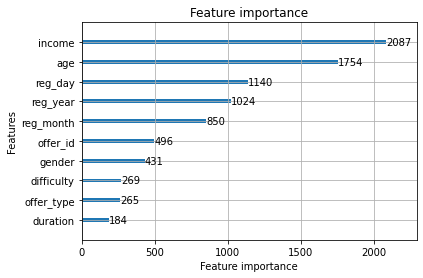

In [26]:
plot_importance(model, importance_type='split', max_num_features=10)

In [27]:
def evaluate_model(model, X_test, y_test, context_col, action_col,
                   n_action = 2, plot_confusion_matrix=True):
  X_test = X_test[context_col]
  y_true = y_test[action_col]
  y_pred = np.array(model.predict(X_test))

  cf_matrix = confusion_matrix(y_true,y_pred)

  cf_matrix_flat = cf_matrix.flatten()
  #n_sample = len(y_true)

  accuracy = accuracy_score(y_true, y_pred)
  print(f"Accuracy = {accuracy * 100:.2f}%")

  if plot_confusion_matrix:

    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = np.asarray(group_percentages).reshape(n_action,n_action)
    ax = plt.axes()
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
              fmt='', cmap='Blues',annot_kws={"fontsize":16}, ax = ax)
    ax.set_title('Confusion Matrix')
    plt.show()

Accuracy = 71.09%


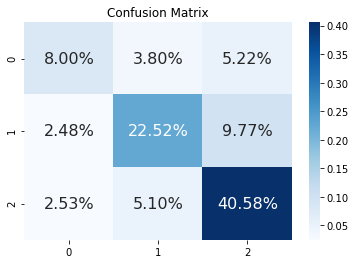

In [28]:
evaluate_model(model, X_test, y_test, context_col, action_col, n_action=num_actions)